__Problem statement__

Given a directed social graph, predict the missing links to recommend users (Link Prediction in graph)

__Data overview__

Facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting data contains two columns source and destination edge in graph - data columns (total 2 columns):
- source_node int64
- destination_node int64

__Mapping the problem into supervised learning problem__

Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link.

Some reference papers and videos :
- https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
- https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
- https://www.youtube.com/watch?v=2M77Hgy17cg

__Business objectives and constraints__

- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links.

__Performance metric for supervised learning__

- Both precision and recall is important so F1 score is good choice.
- Confusion matrix.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split

In [3]:
import csv
import datetime
import math
import networkx as nx
import numpy as np
import os
import pandas as pd
import pdb
import pickle
import random
import seaborn as sns
import time
import xgboost as xgb

In [4]:
style.use(style='seaborn-deep')

In [5]:
if not os.path.isfile(path='data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv(filepath_or_buffer='data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: {}.".format(sum(traincsv.duplicated())))
    traincsv.to_csv(path_or_buf='data/after_eda/train_woheader.csv', header=False, index=False)
    print("Saved the graph into file.")
else:
    g = nx.read_edgelist(path='data/after_eda/train_woheader.csv',
                         delimiter=',',
                         create_using=nx.DiGraph(),
                         nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


In [6]:
total_nodes = len(g.nodes())
total_edges = len(g.edges())

print(total_nodes)
print(total_edges)

1862220
9437519


Displaying a sub graph

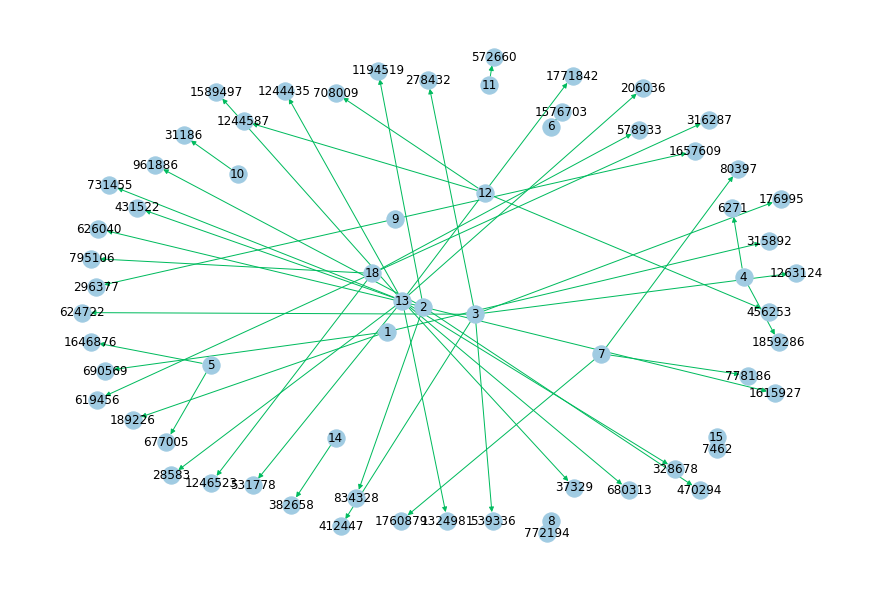

DiGraph with 66 nodes and 50 edges


In [7]:
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

if not os.path.isfile(path='data/after_eda/train_woheader_sample.csv'):
    pd.read_csv(filepath_or_buffer='data/train.csv',
                nrows=50).to_csv(path_or_buf='data/after_eda/train_woheader_sample.csv',
                                 header=False,
                                 index=False)

plt.figure(figsize=(12, 8))
subgraph = nx.read_edgelist(path='data/after_eda/train_woheader_sample.csv',
                            delimiter=',',
                            create_using=nx.DiGraph(),
                            nodetype=int)
pos = nx.spring_layout(G=subgraph)
nx.draw(G=subgraph,
        pos=pos,
        node_color='#A0CBE2',
        edge_color='#00bb5e',
        width=1,
        edge_cmap=plt.cm.Blues,
        with_labels=True)
plt.savefig(fname='graph_sample.pdf')
plt.show()
print(nx.info(subgraph))

__Exploratory Data Analysis__

In [8]:
print("The number of unique persons: {}.".format(len(g.nodes())))

The number of unique persons: 1862220.


Followings and Followers

In [9]:
def plot_followers_and_followings(dist, ylabel):
    """
    This function plots the followings and followers distributions.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dist)
    plt.xlabel(xlabel='Index No')
    plt.ylabel(ylabel=ylabel)
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(indegree_dist[0:1500000])
    plt.xlabel(xlabel='Index No')
    plt.ylabel(ylabel=ylabel)
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(2, 6))
    plt.boxplot(x=indegree_dist)
    plt.ylabel(ylabel=ylabel)
    plt.grid()
    plt.show()
    
    ### 90-100 percentile
    for i in range(0, 11):
        print('The {} percentile value is {}.'.format(90+i, np.percentile(a=dist, q=90+i)))
    print()
    ### 99-100 percentile
    for i in range(10, 110, 10):
        print('The {} percentile value is {}.'.format(99+(i/100), np.percentile(a=dist, q=99+(i/100))))
    
    plt.figure(figsize=(12, 6))
    sns.distplot(a=dist, color='#16A085')
    plt.xlabel(xlabel='PDF of distribution')
    plt.grid()
    plt.show()

Number of __followers__ of each person

In [10]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
indegree_dist = np.array(indegree_dist)

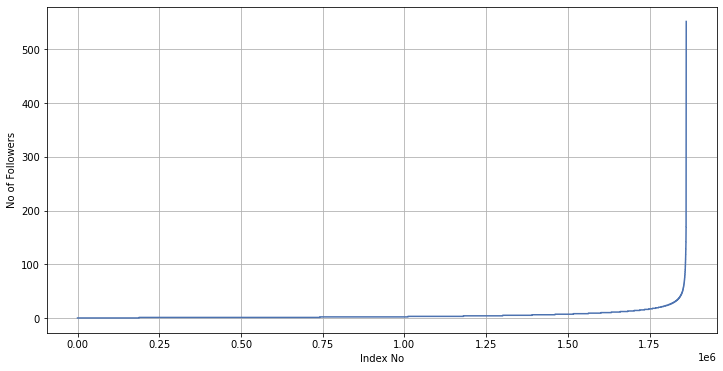

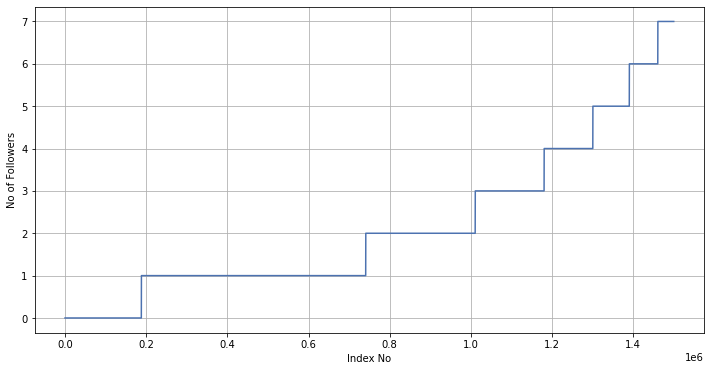

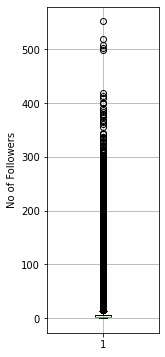

The 90 percentile value is 12.0.
The 91 percentile value is 13.0.
The 92 percentile value is 14.0.
The 93 percentile value is 15.0.
The 94 percentile value is 17.0.
The 95 percentile value is 19.0.
The 96 percentile value is 21.0.
The 97 percentile value is 24.0.
The 98 percentile value is 29.0.
The 99 percentile value is 40.0.
The 100 percentile value is 552.0.

The 99.1 percentile value is 42.0.
The 99.2 percentile value is 44.0.
The 99.3 percentile value is 47.0.
The 99.4 percentile value is 50.0.
The 99.5 percentile value is 55.0.
The 99.6 percentile value is 61.0.
The 99.7 percentile value is 70.0.
The 99.8 percentile value is 84.0.
The 99.9 percentile value is 112.0.
The 100.0 percentile value is 552.0.


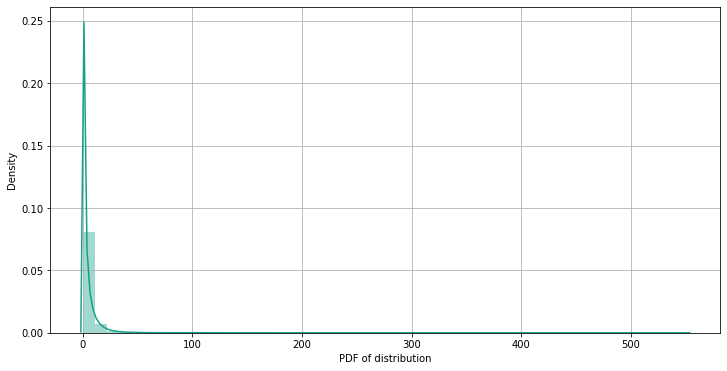

In [11]:
plot_followers_and_followings(dist=indegree_dist, ylabel='No of Followers')

The $99\%$ of data having followers of $40$ only.

Number of __followings__ of each person

In [12]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
outdegree_dist = np.array(outdegree_dist)

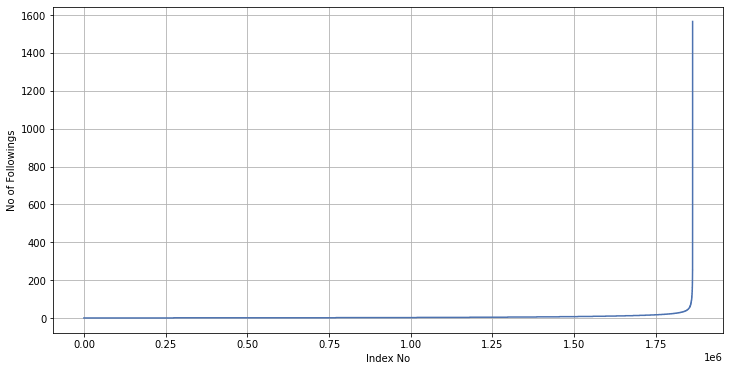

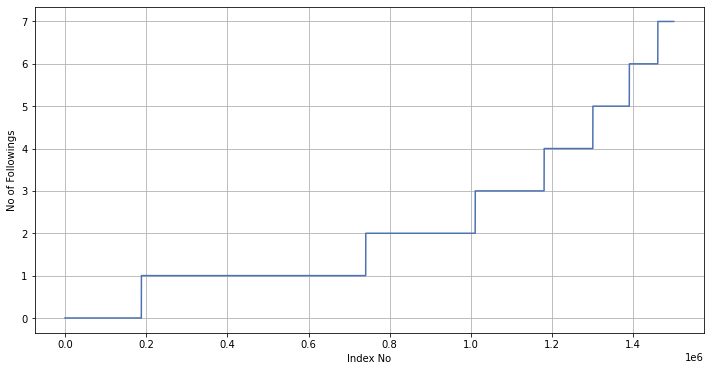

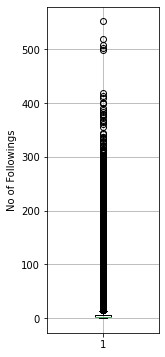

The 90 percentile value is 12.0.
The 91 percentile value is 13.0.
The 92 percentile value is 14.0.
The 93 percentile value is 15.0.
The 94 percentile value is 17.0.
The 95 percentile value is 19.0.
The 96 percentile value is 21.0.
The 97 percentile value is 24.0.
The 98 percentile value is 29.0.
The 99 percentile value is 40.0.
The 100 percentile value is 1566.0.

The 99.1 percentile value is 42.0.
The 99.2 percentile value is 45.0.
The 99.3 percentile value is 48.0.
The 99.4 percentile value is 52.0.
The 99.5 percentile value is 56.0.
The 99.6 percentile value is 63.0.
The 99.7 percentile value is 73.0.
The 99.8 percentile value is 90.0.
The 99.9 percentile value is 123.0.
The 100.0 percentile value is 1566.0.


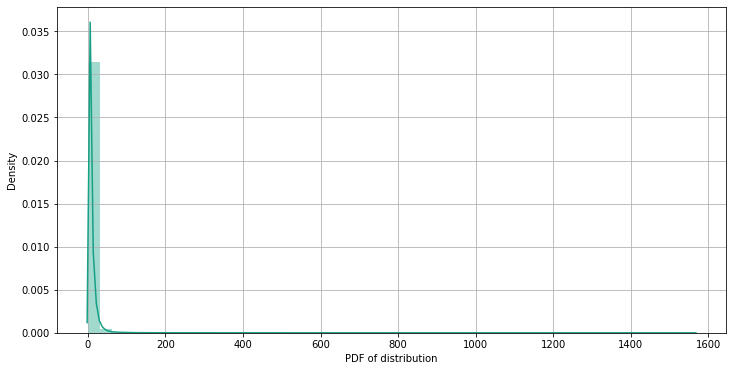

In [13]:
plot_followers_and_followings(dist=outdegree_dist, ylabel='No of Followings')

Zero followers and followings

In [14]:
people_0_followers = sum(indegree_dist == 0)
percent_0_followers = round(people_0_followers * (100 / len(indegree_dist)), 2)
print("The number of people with zero followers: {}.".format(people_0_followers))
print("The percentage of people with zero followers: {}%.".format(percent_0_followers))

The number of people with zero followers: 188043.
The percentage of people with zero followers: 10.1%.


In [15]:
people_0_following = sum(outdegree_dist == 0)
percent_0_following = round(people_0_following * (100 / len(outdegree_dist)), 2)
print("The number of people with zero following: {}.".format(people_0_following))
print("The percentage of people with zero following: {}%.".format(percent_0_following))

The number of people with zero following: 274512.
The percentage of people with zero following: 14.74%.


In [16]:
count = 0
for i in g.nodes():
    if len(list(g.predecessors(i))) == 0:
        if len(list(g.successors(i))) == 0:
            count += 1
print("The number of people those are not following anyone and also not having any followers are: {}.".format(count))

The number of people those are not following anyone and also not having any followers are: 0.


Followers + Following

In [17]:
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())

In [18]:
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = list(d.values())
in_out_degree = np.array(sorted(in_out_degree))

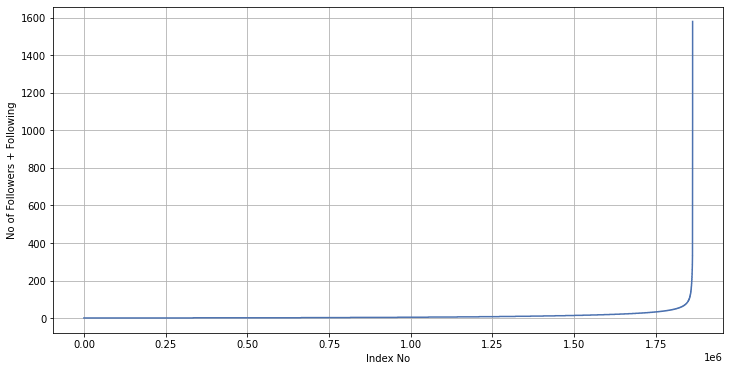

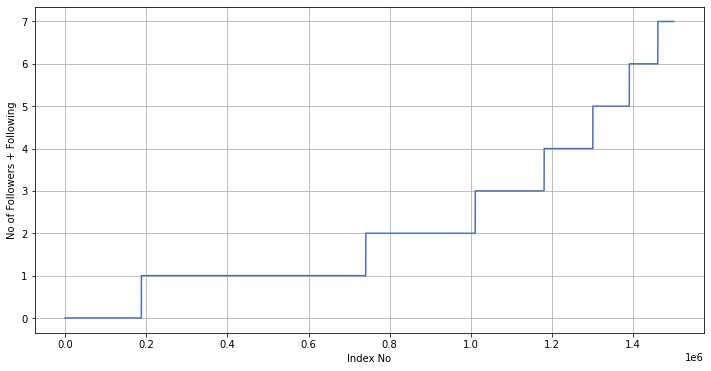

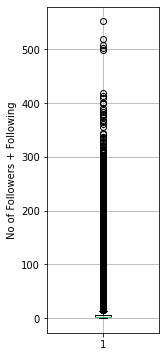

The 90 percentile value is 24.0.
The 91 percentile value is 26.0.
The 92 percentile value is 28.0.
The 93 percentile value is 31.0.
The 94 percentile value is 33.0.
The 95 percentile value is 37.0.
The 96 percentile value is 41.0.
The 97 percentile value is 48.0.
The 98 percentile value is 58.0.
The 99 percentile value is 79.0.
The 100 percentile value is 1579.0.

The 99.1 percentile value is 83.0.
The 99.2 percentile value is 87.0.
The 99.3 percentile value is 93.0.
The 99.4 percentile value is 99.0.
The 99.5 percentile value is 108.0.
The 99.6 percentile value is 120.0.
The 99.7 percentile value is 138.0.
The 99.8 percentile value is 168.0.
The 99.9 percentile value is 221.0.
The 100.0 percentile value is 1579.0.


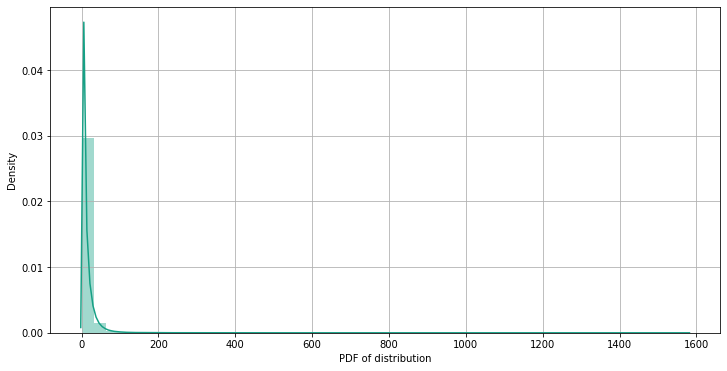

In [19]:
plot_followers_and_followings(dist=in_out_degree, ylabel='No of Followers + Following')

In [20]:
print("The minimum of number of followers + following is: {}.".format(in_out_degree.min()))
print("The {} people have minimum number of followers + following.".format(np.sum(in_out_degree == in_out_degree.min())))

The minimum of number of followers + following is: 1.
The 334291 people have minimum number of followers + following.


In [21]:
print("The maximum of number of followers + following is: {}.".format(in_out_degree.max()))
print("The {} people have maximum number of followers + following.".format(np.sum(in_out_degree == in_out_degree.max())))

The maximum of number of followers + following is: 1579.
The 1 people have maximum number of followers + following.


In [22]:
print("The number of people having followers + following less than 10 are: {}.".format(np.sum(in_out_degree < 10)))

The number of people having followers + following less than 10 are: 1320326.


In [23]:
print("The number of weakly connected components: {}.".format(len(list(nx.weakly_connected_components(g)))))
count = 0
for i in list(nx.weakly_connected_components(g)):
    if len(i) == 2:
        count += 1
print("The weakly connected components with 2 nodes: {}.".format(count))

The number of weakly connected components: 45558.
The weakly connected components with 2 nodes: 32195.


__Posing a problem as classification problem__

Generated bad links from graph which are not present in graph and whose shortest path is greater than 2.

In [24]:
%%time

if not os.path.isfile(path='data/after_eda/missing_edges_final.p'):
    r = csv.reader(open(file='data/after_eda/train_woheader.csv', mode='r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
    
    missing_edges = set()
    while len(missing_edges) < total_edges:
        n1 = random.randint(a=1, b=total_nodes)
        n2 = random.randint(a=1, b=total_nodes)
        tmp = edges.get((n1, n2), -1)
        if tmp == -1 and n1 != n2:
            try:
                if nx.shortest_path_length(G=g, source=n1, target=n2) > 2:
                    missing_edges.add((n1, n2))
                else:
                    continue
            except:
                missing_edges.add((n1, n2))
        else:
            continue
    pickle.dump(obj=missing_edges,
                file=open(file='data/after_eda/missing_edges_final.p', mode='wb'))
else:
    missing_edges = pickle.load(file=open('data/after_eda/missing_edges_final.p', mode='rb'))

CPU times: user 1.4 s, sys: 439 ms, total: 1.84 s
Wall time: 1.84 s


In [25]:
print(len(missing_edges))

9437519


__Training and Test data split__

In [26]:
if ((not os.path.isfile(path='data/after_eda/train_pos_after_eda.csv')) and 
    (not os.path.isfile(path='data/after_eda/test_pos_after_eda.csv'))):
    df_pos = pd.read_csv(filepath_or_buffer='data/train.csv')
    df_neg = pd.DataFrame(data=list(missing_edges), columns=['source_node', 'destination_node'])
    print("Number of nodes in the graph with edges: {}.".format(df_pos.shape[0]))
    print("Number of nodes in the graph without edges: {}.".format(df_neg.shape[0]))
    
    (X_train_pos,
     X_test_pos,
     y_train_pos,
     y_test_pos)  = train_test_split(df_pos,
                                     np.ones(len(df_pos)),
                                     test_size=0.2,
                                     random_state=9)
    (X_train_neg,
     X_test_neg,
     y_train_neg,
     y_test_neg)  = train_test_split(df_neg,
                                     np.zeros(len(df_neg)),
                                     test_size=0.2,
                                     random_state=9)
    print("Number of nodes in the train data graph with edges: {} = {}.".format(X_train_pos.shape[0], y_train_pos.shape[0]))
    print("Number of nodes in the train data graph without edges: {} = {}.".format(X_train_neg.shape[0], y_train_neg.shape[0]))
    print("Number of nodes in the test data graph with edges: {} = {}.".format(X_test_pos.shape[0], y_test_pos.shape[0]))
    print("Number of nodes in the test data graph without edges: {} = {}.".format(X_test_neg.shape[0], y_test_neg.shape[0]))
    
    X_train_pos.to_csv(path_or_buf='data/after_eda/train_pos_after_eda.csv', header=False, index=False)
    X_test_pos.to_csv(path_or_buf='data/after_eda/test_pos_after_eda.csv', header=False, index=False)
    X_train_neg.to_csv(path_or_buf='data/after_eda/train_neg_after_eda.csv', header=False, index=False)
    X_test_neg.to_csv(path_or_buf='data/after_eda/test_neg_after_eda.csv', header=False, index=False)
else:
    del missing_edges

In [27]:
if ((os.path.isfile(path='data/after_eda/train_pos_after_eda.csv')) and 
    (os.path.isfile(path='data/after_eda/test_pos_after_eda.csv'))):
    train_graph = nx.read_edgelist(path='data/after_eda/train_pos_after_eda.csv', 
                                   delimiter=',',
                                   create_using=nx.DiGraph(),
                                   nodetype=int)
    test_graph = nx.read_edgelist(path='data/after_eda/test_pos_after_eda.csv', 
                                  delimiter=',',
                                  create_using=nx.DiGraph(),
                                  nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))
    
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())
    
    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    trN_teY = len(test_nodes_pos - train_nodes_pos)
    print("Number of people common in train and test: {}.".format(trY_teY))
    print("Number of people present in train but not present in test: {}.".format(trY_teN))
    print("Number of people present in test but not present in train: {}.".format(trN_teY))
    per = trN_teY / len(test_nodes_pos) * 100
    print("The % of people not there in train but exist in test in total test data are: {}%.".format(round(per, 2)))

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
Number of people common in train and test: 1063125.
Number of people present in train but not present in test: 717597.
Number of people present in test but not present in train: 81498.
The % of people not there in train but exist in test in total test data are: 7.12%.


We have a cold start problem here.

In [28]:
if ((not os.path.isfile(path='data/after_eda/train_after_eda.csv')) and 
    (not os.path.isfile(path='data/after_eda/test_after_eda.csv')) and 
    (not os.path.isfile(path='data/train_y.csv')) and 
    (not os.path.isfile(path='data/test_y.csv')) and 
    (os.path.isfile(path='data/after_eda/train_pos_after_eda.csv')) and 
    (os.path.isfile(path='data/after_eda/test_pos_after_eda.csv')) and 
    (os.path.isfile(path='data/after_eda/train_neg_after_eda.csv')) and 
    (os.path.isfile(path='data/after_eda/test_neg_after_eda.csv'))):
    X_train_pos = pd.read_csv(filepath_or_buffer='data/after_eda/train_pos_after_eda.csv',
                              names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv(filepath_or_buffer='data/after_eda/test_pos_after_eda.csv',
                             names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv(filepath_or_buffer='data/after_eda/train_neg_after_eda.csv',
                              names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv(filepath_or_buffer='data/after_eda/test_neg_after_eda.csv',
                             names=['source_node', 'destination_node'])
    print("Number of nodes in the train data graph with edges: {}.".format(X_train_pos.shape[0]))
    print("Number of nodes in the train data graph without edges: {}.".format(X_train_neg.shape[0]))
    print("Number of nodes in the test data graph with edges: {}.".format(X_test_pos.shape[0]))
    print("Number of nodes in the test data graph without edges: {}.".format(X_test_neg.shape[0]))
    
    X_train = X_train_pos.concat(objs=X_train_neg, ignore_index=True)
    y_train = np.concatenate((y_train_pos, y_train_neg))
    X_test = X_test_pos.concat(objs=X_test_neg, ignore_index=True)
    y_test = np.concatenate((y_test_pos, y_test_neg))
    
    X_train.to_csv(path_or_buf='data/after_eda/train_after_eda.csv', header=False, index=False)
    X_test.to_csv(path_or_buf='data/after_eda/test_after_eda.csv', header=False, index=False)
    pd.DataFrame(data=y_train.astype(int)).to_csv(path_or_buf='data/train_y.csv', header=False, index=False)
    pd.DataFrame(data=y_test.astype(int)).to_csv(path_or_buf='data/test_y.csv', header=False, index=False)